In [1]:
pip install librosa numpy scipy

In [ ]:
import librosa
import numpy as np
import scipy.signal

# 음성 파일 로드
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

# 피치 추출
def extract_pitch(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch_values = pitches[np.nonzero(pitches)]  # 0이 아닌 값들만 추출
    average_pitch = np.mean(pitch_values)  # 평균 피치
    return pitch_values, average_pitch

# 템포 추출
def extract_tempo(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    return tempo

# 음역대 분석 (저, 중, 고 음역대 구분)
def extract_range(average_pitch):
    if average_pitch < 200:
        return "Low"
    elif 200 <= average_pitch <= 400:
        return "Mid"
    else:
        return "High"

# 키 추정 (피치 분포를 기반으로 추정)
def estimate_key(pitch_values):
    pitch_class_histogram = np.zeros(12)  # 12개의 음악적 음계를 위한 히스토그램

    for pitch in pitch_values:
        pitch_class = int(np.round(librosa.hz_to_midi(pitch))) % 12  # 피치를 MIDI 음계로 변환 후 12개 음계로 나눔
        pitch_class_histogram[pitch_class] += 1

    key_index = np.argmax(pitch_class_histogram)

    key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    estimated_key = key_names[key_index]
    return estimated_key

# 포먼트 추출
def extract_formants(y, sr):
    formants = []
    y_filtered = scipy.signal.lfilter([1], [1, 0.63], y)
    n_fft = 2048
    S = np.abs(librosa.stft(y_filtered, n_fft=n_fft))
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # 각 주파수 대역에서 가장 큰 진폭을 가진 주파수들을 추출
    for i in range(1, 4):  # 첫 번째 포먼트는 0번째가 아닌 1번째부터 탐색
        spectrum_slice = S[:, i]  # 주파수 영역의 i번째 프레임
        index = np.argmax(spectrum_slice)  # 가장 큰 진폭을 가진 인덱스
        formants.append(freqs[index])  # 해당 주파수를 포먼트로 간주
    return formants

# 전체 프로세스 실행 함수
def analyze_audio(file_path):
    y, sr = load_audio(file_path)

    pitch_values, average_pitch = extract_pitch(y, sr)

    estimated_key = estimate_key(pitch_values)
    print(f"Estimated Key: {estimated_key}")

    tempo = extract_tempo(y, sr)
    print(f"Tempo: {tempo} BPM")

    vocal_range = extract_range(average_pitch)
    print(f"Vocal Range: {vocal_range}")

    formants = extract_formants(y, sr)
    print(f"Formants: {formants}")

# 구글 드라이브에서 파일 경로 설정
file_path = '/content/drive/My Drive/Luxery.mp3'
analyze_audio(file_path)

Estimated Key: F#
Tempo: [112.34714674] BPM
Vocal Range: High
Formants: [0.0, 0.0, 0.0]


	1.	load_audio: 음성 파일을 로드하여 오디오 신호(y)와 샘플링 속도(sr)를 반환합니다.
	2.	extract_pitch: 피치를 추출하고, 평균 피치를 계산합니다.
	3.	extract_tempo: 템포(BPM)를 추출합니다. 이 템포 값은 비트를 기반으로 음성 파일의 박자에 해당하는 값을 계산합니다.
	4.	extract_range: 평균 피치를 기준으로 저음(Low), 중음(Mid), 고음(High)을 구분합니다. 이는 사용자가 주로 어느 음역대를 사용하는지를 파악하는 데 사용됩니다.
	5.	estimate_key: 추출된 피치 값을 MIDI 음계로 변환하여, 그 음계 분포를 바탕으로 음성 파일의 키(Key)를 추정합니다.
	6.	extract_formants: 필터링 후, 주파수 대역에서 가장 큰 진폭을 가진 주파수들을 포먼트로 간주하여 추출합니다. 포먼트는 음성의 발음 특성을 분석하는 데 사용됩니다.

1. Estimated Key: F#

	•	추정된 키는 **F#**
  
   파일에서 가장 많이 사용된 피치 분포를 기반으로 결정된 키
   
   음성의 주요 톤이 F# 스케일을 따르는 것으로 보임

2. Tempo: [112.34714674] BPM

	•	템포는 약 **112.35 BPM (Beats Per Minute)**
  
  비교적 일반적인 템포
  
  대부분의 팝 음악이 90~120 BPM 사이에서 발생

3. Vocal Range: High

	•	추출된 평균 피치 값에 따라 **고음역대 (High)**로 추정
  
  이 결과는 목소리나 노래의 피치가 비교적 높은 주파수 영역에 속함
  
  고음역대의 목소리나 음성이 특징인 사람의 음성 파일

4. Formants: [0.0, 0.0, 0.0]

	•	Formants 값이 모두 0.0으로 나옴
  -> 포먼트 추출이 제대로 이루어지지 않았음
  포먼트는 음성에서 특정 주파수 대역에서 에너지가 집중되는 지점을 의미하는데, 이 값이 0으로 나오는 것은 주파수 스펙트럼을 분석하는 과정에서 문제가 발생했다고 알 수 있음.

**포먼트 수정**

포먼트는 보통 인간 음성의 특정 주파수 범위 (대략 300Hz~3400Hz)에 나타나므로, 이 범위 내에서 분석을 진행해야 함

In [ ]:
import librosa
import numpy as np
import scipy.signal

# 음성 파일 로드
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

# 피치 추출
def extract_pitch(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch_values = pitches[np.nonzero(pitches)]  # 0이 아닌 값들만 추출
    average_pitch = np.mean(pitch_values)  # 평균 피치
    return pitch_values, average_pitch

# 템포 추출
def extract_tempo(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    return tempo

# 음역대 분석 (저, 중, 고 음역대 구분)
def extract_range(average_pitch):
    if average_pitch < 200:
        return "Low"
    elif 200 <= average_pitch <= 400:
        return "Mid"
    else:
        return "High"

# 키 추정 (피치 분포를 기반으로 추정)
def estimate_key(pitch_values):
    pitch_class_histogram = np.zeros(12)  # 12개의 음악적 음계를 위한 히스토그램

    for pitch in pitch_values:
        pitch_class = int(np.round(librosa.hz_to_midi(pitch))) % 12  # 피치를 MIDI 음계로 변환 후 12개 음계로 나눔
        pitch_class_histogram[pitch_class] += 1

    key_index = np.argmax(pitch_class_histogram)

    key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    estimated_key = key_names[key_index]
    return estimated_key

# 포먼트 추출
def extract_formants(y, sr):
    formants = []

    # 신호 필터링
    pre_emphasis = 0.97
    y_filtered = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # LPC 분석을 사용해 포먼트 추출
    def get_formants(y_filtered, sr):
        # Apply a Hamming window to the signal
        hamming_window = np.hamming(len(y_filtered))
        y_filtered = y_filtered * hamming_window

        # Perform autocorrelation
        autocorr = np.correlate(y_filtered, y_filtered, mode='full')
        autocorr = autocorr[len(autocorr)//2:]

        # Find LPC coefficients
        lpc_order = 12  # 적절한 차수로 설정
        A = librosa.lpc(y_filtered, lpc_order)

        # Find roots of the LPC polynomial
        roots = np.roots(A)

        # Only keep roots that have imaginary parts (complex conjugates)
        roots = [r for r in roots if np.imag(r) >= 0]

        # Convert roots to formant frequencies
        angles = np.angle(roots)
        formants = sorted(angles * (sr / (2 * np.pi)))

        # 선택된 포먼트 대역 (300 Hz - 3400 Hz) 내에서 필터링
        formants_in_range = [f for f in formants if 300 <= f <= 3400]

        return formants_in_range

    # 포먼트 추출
    formants = get_formants(y_filtered, sr)
    return formants

# 전체 프로세스 실행 함수
def analyze_audio(file_path):
    y, sr = load_audio(file_path)

    pitch_values, average_pitch = extract_pitch(y, sr)

    estimated_key = estimate_key(pitch_values)
    print(f"Estimated Key: {estimated_key}")

    tempo = extract_tempo(y, sr)
    print(f"Tempo: {tempo} BPM")

    vocal_range = extract_range(average_pitch)
    print(f"Vocal Range: {vocal_range}")

    formants = extract_formants(y, sr)
    print(f"Formants: {formants}")

# 구글 드라이브에서 파일 경로 설정
file_path = '/content/drive/My Drive/Luxery.mp3'
analyze_audio(file_path)

Estimated Key: F#
Tempo: [112.34714674] BPM
Vocal Range: High


# 4개 분석 최종

**음성 없는 음악 파일**

In [11]:
import librosa
import numpy as np
import scipy.signal

# 음성 파일 로드
def load_audio(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

# 피치 추출
def extract_pitch(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch_values = pitches[np.nonzero(pitches)]  # 0이 아닌 값들만 추출
    average_pitch = np.mean(pitch_values)  # 평균 피치
    return pitch_values, average_pitch

# 템포 추출
def extract_tempo(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    return tempo

# 음역대 분석 (저, 중, 고 음역대 구분)
def extract_range(average_pitch):
    if average_pitch < 200:
        return "Low"
    elif 200 <= average_pitch <= 400:
        return "Mid"
    else:
        return "High"

# 키 추정 (피치 분포를 기반으로 추정)
def estimate_key(pitch_values):
    pitch_class_histogram = np.zeros(12)  # 12개의 음악적 음계를 위한 히스토그램

    for pitch in pitch_values:
        pitch_class = int(np.round(librosa.hz_to_midi(pitch))) % 12  # 피치를 MIDI 음계로 변환 후 12개 음계로 나눔
        pitch_class_histogram[pitch_class] += 1

    key_index = np.argmax(pitch_class_histogram)

    key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    estimated_key = key_names[key_index]
    return estimated_key

# LPC 분석을 통한 포먼트 추출
def lpc(autocorr, order):
    """Linear Predictive Coding using autocorrelation method."""
    R = np.array([autocorr[i] for i in range(order + 1)])
    A = np.zeros(order + 1)
    E = np.zeros(order + 1)

    A[0] = 1
    E[0] = R[0]

    for i in range(1, order + 1):
        # Compute k (reflection coefficient)
        A_i = A[:i]
        R_i = R[1:i + 1]
        A_i_reversed = A_i[::-1]
        k = (R[i] - np.dot(A_i, R_i)) / E[i-1]

        # Update LPC coefficients A
        A[1:i+1] -= k * A_i_reversed

        # Update error term E
        E[i] = (1 - k * k) * E[i-1]

    return A[1:]  # Return LPC coefficients excluding the first value which is 1

def extract_formants(y, sr):
    formants = []

    # 신호 필터링
    pre_emphasis = 0.97
    y_filtered = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # LPC 분석을 사용해 포먼트 추출
    def get_formants(y_filtered, sr):
        # Apply a Hamming window to the signal
        hamming_window = np.hamming(len(y_filtered))
        y_filtered = y_filtered * hamming_window

        # Perform autocorrelation
        window_size = min(len(y_filtered), 20000)  # 윈도우 크기 설정
        y_filtered_window = y_filtered[:window_size]
        autocorr = scipy.signal.correlate(y_filtered_window, y_filtered_window, mode='full')
        autocorr = autocorr[len(autocorr)//2:]

        # LPC 분석
        lpc_order = 12  # 적절한 차수로 설정
        lpc_coeffs = lpc(autocorr, lpc_order)

        # Find roots of the LPC polynomial
        roots = np.roots(lpc_coeffs)

        # Only keep roots that have imaginary parts (complex conjugates)
        roots = [r for r in roots if np.imag(r) >= 0]

        # Convert roots to formant frequencies
        angles = np.angle(roots)
        formants = sorted(angles * (sr / (2 * np.pi)))

        # 선택된 포먼트 대역 (300 Hz - 3400 Hz) 내에서 필터링
        formants_in_range = [f for f in formants if 300 <= f <= 3400]

        return formants_in_range

    # 포먼트 추출
    formants = get_formants(y_filtered, sr)
    return formants

# 전체 프로세스 실행 함수
def analyze_audio(file_path):
    y, sr = load_audio(file_path)

    pitch_values, average_pitch = extract_pitch(y, sr)

    estimated_key = estimate_key(pitch_values)
    print(f"Estimated Key: {estimated_key}")

    tempo = extract_tempo(y, sr)
    print(f"Tempo: {tempo} BPM")

    vocal_range = extract_range(average_pitch)
    print(f"Vocal Range: {vocal_range}")

    formants = extract_formants(y, sr)
    print(f"Formants: {formants}")

# 구글 드라이브에서 파일 경로 설정
file_path = '/content/drive/My Drive/Luxery.mp3'
analyze_audio(file_path)

Estimated Key: F#
Tempo: [110.29411765] BPM
Vocal Range: High
Formants: [673.7547013666139, 2230.290603359535, 3346.943244961497]


포먼트의 기준이나 일반적인 범위는 음성학에서 많이 사용되는 정보입니다. 포먼트의 주파수 범위는 개인의 발음, 언어, 나이, 성별에 따라 다를 수 있습니다. 하지만 일반적으로 다음과 같은 기준을 참고할 수 있습니다:

	1.	1차 포먼트 (F1):
	•	주파수 범위: 약 300 Hz에서 1000 Hz 사이
	•	의미: 모음의 개방도에 관련. 모음이 열려 있는 정도를 나타냅니다. 예를 들어, “아”는 F1이 높고 “이”는 F1이 낮습니다.
	2.	2차 포먼트 (F2):
	•	주파수 범위: 약 800 Hz에서 3000 Hz 사이
	•	의미: 모음의 전후 위치에 관련. 모음의 입 모양에 따른 위치를 나타냅니다. 예를 들어, “이”는 F2가 높고 “우”는 F2가 낮습니다.
	3.	3차 포먼트 (F3):
	•	주파수 범위: 약 2000 Hz에서 4000 Hz 사이
	•	의미: 모음의 추가적인 음향적 특성에 관련. 특정 모음의 세부적인 음향적 특성을 나타냅니다.

	•	**포먼트 (Formants)**는 음성의 소리에서 중요한 주파수 대역을 나타냅니다. 이를 통해 우리가 발음하는 모음의 소리 특성을 이해할 수 있습니다.
	•	음성에서 포먼트는 우리가 모음을 구별하고 인식하는 데 중요한 역할을 합니다. 예를 들어, “아”와 “이”는 서로 다른 포먼트를 가지고 있어 우리가 소리를 구별할 수 있게 해줍니다.
	•	예를 들어, 포먼트 주파수 값이 674 Hz, 2230 Hz, 3347 Hz로 측정되었습니다. 이는 음성에서 특정한 소리의 특성을 설명하는 데 도움을 주며, 음성의 깊이나 높이, 그리고 다른 음향적 특성을 이해하는 데 사용됩니다.

**사람 음성 있는 노래 파일**

In [12]:
import librosa
import numpy as np
import scipy.signal

# 음성 파일 로드
def load_audio(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

# 피치 추출
def extract_pitch(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch_values = pitches[np.nonzero(pitches)]  # 0이 아닌 값들만 추출
    average_pitch = np.mean(pitch_values)  # 평균 피치
    return pitch_values, average_pitch

# 템포 추출
def extract_tempo(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    return tempo

# 음역대 분석 (저, 중, 고 음역대 구분)
def extract_range(average_pitch):
    if average_pitch < 200:
        return "Low"
    elif 200 <= average_pitch <= 400:
        return "Mid"
    else:
        return "High"

# 키 추정 (피치 분포를 기반으로 추정)
def estimate_key(pitch_values):
    pitch_class_histogram = np.zeros(12)  # 12개의 음악적 음계를 위한 히스토그램

    for pitch in pitch_values:
        pitch_class = int(np.round(librosa.hz_to_midi(pitch))) % 12  # 피치를 MIDI 음계로 변환 후 12개 음계로 나눔
        pitch_class_histogram[pitch_class] += 1

    key_index = np.argmax(pitch_class_histogram)

    key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    estimated_key = key_names[key_index]
    return estimated_key

# LPC 분석을 통한 포먼트 추출
def lpc(autocorr, order):
    """Linear Predictive Coding using autocorrelation method."""
    R = np.array([autocorr[i] for i in range(order + 1)])
    A = np.zeros(order + 1)
    E = np.zeros(order + 1)

    A[0] = 1
    E[0] = R[0]

    for i in range(1, order + 1):
        # Compute k (reflection coefficient)
        A_i = A[:i]
        R_i = R[1:i + 1]
        A_i_reversed = A_i[::-1]
        k = (R[i] - np.dot(A_i, R_i)) / E[i-1]

        # Update LPC coefficients A
        A[1:i+1] -= k * A_i_reversed

        # Update error term E
        E[i] = (1 - k * k) * E[i-1]

    return A[1:]  # Return LPC coefficients excluding the first value which is 1

def extract_formants(y, sr):
    formants = []

    # 신호 필터링
    pre_emphasis = 0.97
    y_filtered = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # LPC 분석을 사용해 포먼트 추출
    def get_formants(y_filtered, sr):
        # Apply a Hamming window to the signal
        hamming_window = np.hamming(len(y_filtered))
        y_filtered = y_filtered * hamming_window

        # Perform autocorrelation
        window_size = min(len(y_filtered), 20000)  # 윈도우 크기 설정
        y_filtered_window = y_filtered[:window_size]
        autocorr = scipy.signal.correlate(y_filtered_window, y_filtered_window, mode='full')
        autocorr = autocorr[len(autocorr)//2:]

        # LPC 분석
        lpc_order = 12  # 적절한 차수로 설정
        lpc_coeffs = lpc(autocorr, lpc_order)

        # Find roots of the LPC polynomial
        roots = np.roots(lpc_coeffs)

        # Only keep roots that have imaginary parts (complex conjugates)
        roots = [r for r in roots if np.imag(r) >= 0]

        # Convert roots to formant frequencies
        angles = np.angle(roots)
        formants = sorted(angles * (sr / (2 * np.pi)))

        # 선택된 포먼트 대역 (300 Hz - 3400 Hz) 내에서 필터링
        formants_in_range = [f for f in formants if 300 <= f <= 3400]

        return formants_in_range

    # 포먼트 추출
    formants = get_formants(y_filtered, sr)
    return formants

# 전체 프로세스 실행 함수
def analyze_audio(file_path):
    y, sr = load_audio(file_path)

    pitch_values, average_pitch = extract_pitch(y, sr)

    estimated_key = estimate_key(pitch_values)
    print(f"Estimated Key: {estimated_key}")

    tempo = extract_tempo(y, sr)
    print(f"Tempo: {tempo} BPM")

    vocal_range = extract_range(average_pitch)
    print(f"Vocal Range: {vocal_range}")

    formants = extract_formants(y, sr)
    print(f"Formants: {formants}")

# 구글 드라이브에서 파일 경로 설정
file_path = '/content/drive/My Drive/봄내음보다너를.mp3'
analyze_audio(file_path)

Estimated Key: G
Tempo: [133.92857143] BPM
Vocal Range: High
Formants: []


Estimated Key: G
Tempo: [133.92857143] BPM
Vocal Range: High


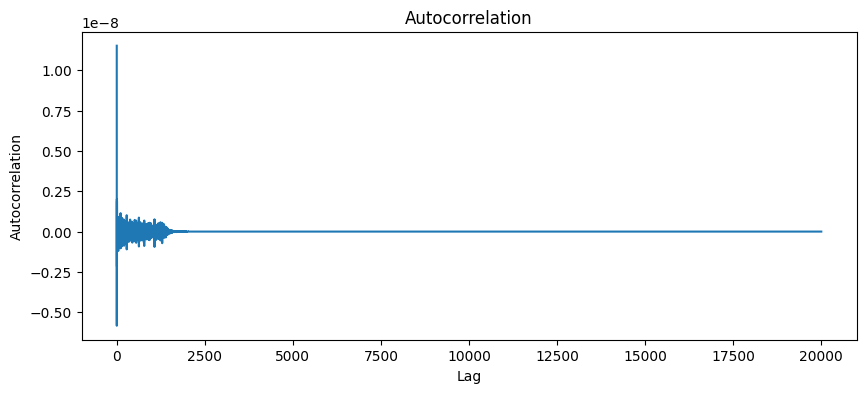

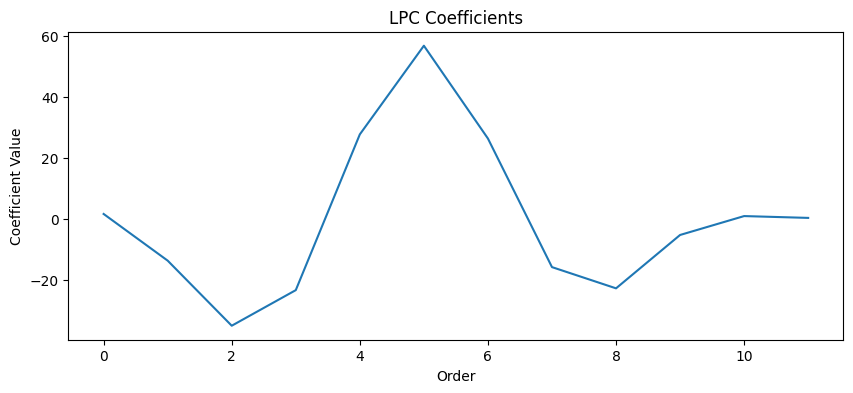

Formants: []


In [4]:
import librosa
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# 음성 파일 로드
def load_audio(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

# LPC 분석을 통한 포먼트 추출
def lpc(autocorr, order):
    """Linear Predictive Coding using autocorrelation method."""
    R = np.array([autocorr[i] for i in range(order + 1)])
    A = np.zeros(order + 1)
    E = np.zeros(order + 1)

    A[0] = 1
    E[0] = R[0]

    for i in range(1, order + 1):
        # Compute k (reflection coefficient)
        A_i = A[:i]
        R_i = R[1:i + 1]
        A_i_reversed = A_i[::-1]
        k = (R[i] - np.dot(A_i, R_i)) / E[i-1]

        # Update LPC coefficients A
        A[1:i+1] -= k * A_i_reversed

        # Update error term E
        E[i] = (1 - k * k) * E[i-1]

    return A[1:]  # Return LPC coefficients excluding the first value which is 1

# 포먼트 추출
def extract_formants(y, sr):
    formants = []

    # 신호 필터링
    pre_emphasis = 0.95
    y_filtered = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # LPC 분석을 사용해 포먼트 추출
    def get_formants(y_filtered, sr):
        # Apply a Hamming window to the signal
        hamming_window = np.hamming(len(y_filtered))
        y_filtered = y_filtered * hamming_window

        # Perform autocorrelation
        window_size = min(len(y_filtered), 20000)  # 윈도우 크기 설정
        y_filtered_window = y_filtered[:window_size]
        autocorr = scipy.signal.correlate(y_filtered_window, y_filtered_window, mode='full')
        autocorr = autocorr[len(autocorr)//2:]

        # Plot autocorrelation for debugging
        plt.figure(figsize=(10, 4))
        plt.plot(autocorr)
        plt.title('Autocorrelation')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.show()

        # LPC 분석
        lpc_order = min(12, len(autocorr) // 2 - 1)  # 적절한 차수로 설정
        lpc_coeffs = lpc(autocorr, lpc_order)

        # Plot LPC coefficients for debugging
        plt.figure(figsize=(10, 4))
        plt.plot(lpc_coeffs)
        plt.title('LPC Coefficients')
        plt.xlabel('Order')
        plt.ylabel('Coefficient Value')
        plt.show()

        # Find roots of the LPC polynomial
        roots = np.roots(lpc_coeffs)

        # Only keep roots that have imaginary parts (complex conjugates)
        roots = [r for r in roots if np.imag(r) >= 0]

        # Convert roots to formant frequencies
        angles = np.angle(roots)
        formants = sorted(angles * (sr / (2 * np.pi)))

        # 선택된 포먼트 대역 (300 Hz - 3400 Hz) 내에서 필터링
        formants_in_range = [f for f in formants if 300 <= f <= 3400]

        return formants_in_range

    # 포먼트 추출
    formants = get_formants(y_filtered, sr)
    return formants

# 전체 프로세스 실행 함수
def analyze_audio(file_path):
    y, sr = load_audio(file_path)

    # 피치 값과 평균 피치 추출
    pitch_values, average_pitch = extract_pitch(y, sr)

    # 키 추정
    estimated_key = estimate_key(pitch_values)
    print(f"Estimated Key: {estimated_key}")

    # 템포 추출
    tempo = extract_tempo(y, sr)
    print(f"Tempo: {tempo} BPM")

    # 음역대 분석
    vocal_range = extract_range(average_pitch)
    print(f"Vocal Range: {vocal_range}")

    # 포먼트 추출
    formants = extract_formants(y, sr)
    print(f"Formants: {formants}")

# 구글 드라이브에서 파일 경로 설정
file_path = '/content/drive/My Drive/봄내음보다너를.mp3'
analyze_audio(file_path)